In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from tqdm import tqdm
from scipy.misc import logsumexp

In [5]:
# Generate synthetic data
means = np.array([ 1, 2, 3])
sigmas = np.array([0.2, 0.3, 0.1])
coef = np.array([0.2, 0.3, 0.5])
cdf = np.cumsum(coef)

samples = np.zeros([5000])
for i in range(samples.shape[0]):
    rand = np.random.random()
    m = cdf.searchsorted(rand)
    samples[i] = sigmas[m]*np.random.randn() + means[m]

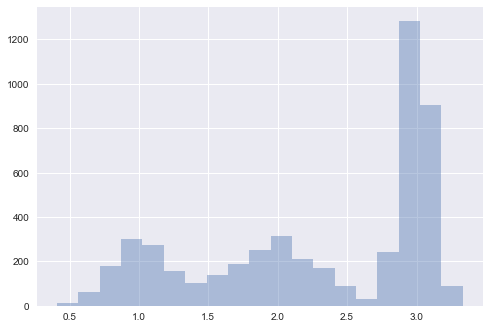

In [6]:
seaborn.distplot(samples, kde=False)

In [7]:
# Gibbs Bayesian GMM fit
K=3
# compute p(Z_i=k|X_i, mu, sigma, pi) { pi_k*N(x_i|mu_k, sigma_k)
def compute_p_z_k(samples, pi_sampled, mean_sampled, sigma_sampled):
    # Maximizes z_i
    lengths = samples.shape[0]
    K = 3
    p_z_k = np.zeros((lengths, K))
    for i in range(lengths):
        for k in range(K):
            C = 1.0 / (np.sqrt(2.0 * np.pi) * sigma_sampled[k])
            p_z_k[i][k] = pi_sampled[k]*(C * np.exp(-0.5 * ((samples[i]-mean_sampled[k])/sigma_sampled[k])**2))
        # normalize
        p_z_k[i] /= p_z_k[i].sum()
    return p_z_k

def vect_compute_p_z_k(samples, pi_sampled, mean_sampled, sigma_sampled):
    prior = np.log(pi_sampled)
    p_z_k = -0.5 * np.log(2*np.pi) + -0.5*np.log(sigma_sampled) + -0.5*((samples[:, np.newaxis] - mean_sampled)/sigma_sampled)**2
    p_z_k = prior + p_z_k
    #C = 1.0/(np.sqrt(2*np.pi) * sigma_sampled)
    #p_z_k = pi_sampled * (C * np.exp(-0.5*((samples[:, np.newaxis] - mean_sampled)/sigma_sampled)**2))
    #normalize
    pvals = np.exp(p_z_k - logsumexp(p_z_k, axis=1)[:, np.newaxis])
    #p_z_k /= p_z_k.sum(1)[:, np.newaxis]
    return pvals

def max_zi(p_z_k, X):
    z_i = np.zeros(X)
    for i, j in enumerate(p_z_k):
        z_i[i] = np.where(j == j.max())[0]
    return z_i

def sample_z_i_mult(p_z_k, X):
    z_i = np.zeros(X)
    components = np.array([0,1,2])
    for i, j in enumerate(p_z_k):
        z_i[i] = np.where(np.random.multinomial(n=1, pvals=j))[0][0]
    return z_i    

def sample_z_i(p_z_k, X):
    z_i = np.zeros(X, dtype='int64')
    components = np.array([0,1,2])
    for i, j in enumerate(p_z_k):
        z_i[i] = np.random.choice(components, 1, p=j)
    return z_i    

def count(z_i):
    counts = np.zeros(K)
    for i in range(K):
        counts[i] = len(np.where(z_i==i)[0])
    return counts

def counts_bgmm(z_i):
    counts = np.bincount(z_i)
    return counts

def sample_pi(counts, alpha):
    pi_sampled = np.random.dirichlet(alpha+counts)
    return pi_sampled

def sample_stats(samples, counts, mean_sampled, sigma_sampled, z_i):
    for i in range(K):
        if counts[i] == 0:
            mean_sampled[i] = 0
            print('warning, no samples in component')
        if counts[i] > 0:
            mean_sampled[i] = np.random.randn()*sigma_sampled[i]/np.sqrt(counts[i]) + np.mean(samples[np.where(z_i==i)])
        if counts[i] > 1:
            # Use improper Jeffreys prior for sigma
            chisquared = np.random.chisquare(df=(counts[i] - 1))
            sigmahat2 = np.mean((samples[np.where(z_i==i)] - mean_sampled[i])**2)
            sigma_sampled[i] = np.sqrt(sigmahat2)/np.sqrt(chisquared/counts[i])
    return mean_sampled, sigma_sampled

In [8]:
def gibbs_sampler(samples, niter):
    # randomly initialize pi, m_k, sigma_k
    K = 3
    stats = {'pi':np.zeros((niter, K)), 'mean':np.zeros((niter, K)), 'sigma':np.zeros((niter, K)), 'z': np.zeros((niter, samples.shape[0]))}
    pi_sampled = np.random.dirichlet((1,1,1))
    mean_sampled = np.random.uniform(low=2, high=6, size=3)
    sigma_sampled = np.random.uniform(low=0.01, high=1, size=3)
    stats['pi'][0] = pi_sampled
    stats['mean'][0] = mean_sampled
    stats['sigma'][0] = sigma_sampled
    alpha = np.ones(K)
    for i in tqdm(range(1,niter)):
        p_z = vect_compute_p_z_k(samples, pi_sampled, mean_sampled, sigma_sampled)
        z_i = sample_z_i_mult(p_z, samples.shape[0])
        stats['z'][i] = z_i 
        counts = count(z_i)
        stats['pi'][i] = sample_pi(counts, alpha)
        stats['mean'][i], stats['sigma'][i] = sample_stats(samples, counts, mean_sampled, sigma_sampled, z_i)
        # update alpha
        #alpha = counts 
    return stats
    

In [9]:
stats = gibbs_sampler(samples, 500)

100%|██████████| 499/499 [00:14<00:00, 34.20it/s]


In [10]:
print('True Pi: %s' % coef)
print('estimated: %s' % stats['pi'][-1])
stats['pi'][-2]

True Pi: [ 0.2  0.3  0.5]
estimated: [ 0.48418416  0.36990673  0.14590911]


array([ 0.48675357,  0.38794752,  0.12529891])

In [11]:
print ('True means: %s' % means)
print('estimated means: %s' % stats['mean'][-1])


True means: [1 2 3]
estimated means: [ 3.00342933  1.84683309  0.96242139]


In [12]:
print('True sigmas: %s' % sigmas)
print('estimated sigmas: %s' % stats['sigma'][-1])

True sigmas: [ 0.2  0.3  0.1]
estimated sigmas: [ 0.0937145   0.49212301  0.15711769]


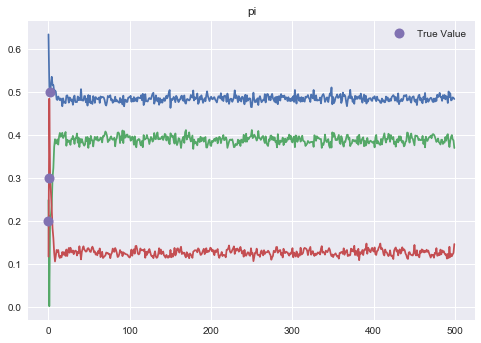

In [13]:
plt.plot(stats['pi'][:,0])
plt.plot(stats['pi'][:,1])
plt.plot(stats['pi'][:,2])
plt.title('pi')
plt.plot(coef, '.', markersize=20, label='True Value')
plt.legend()

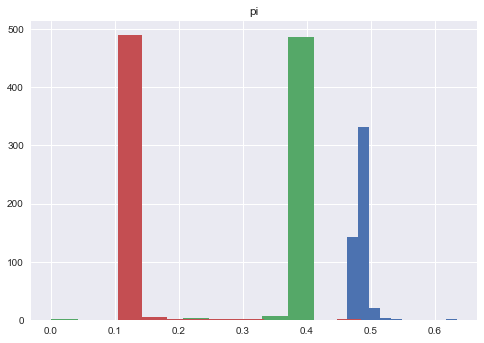

In [14]:
plt.hist(stats['pi'][:,0]);
plt.hist(stats['pi'][:,1]);
plt.hist(stats['pi'][:,2]);
plt.title('pi')
#plt.plot(coef, '.', markersize=20, label='True Value')
#plt.legend()

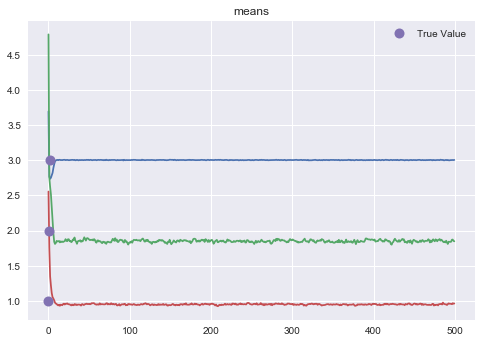

In [15]:
plt.plot(stats['mean'][:,0]);
plt.plot(stats['mean'][:,1]);
plt.plot(stats['mean'][:,2]);
plt.title('means')
plt.plot(means, '.', markersize=20, label='True Value');
plt.legend();

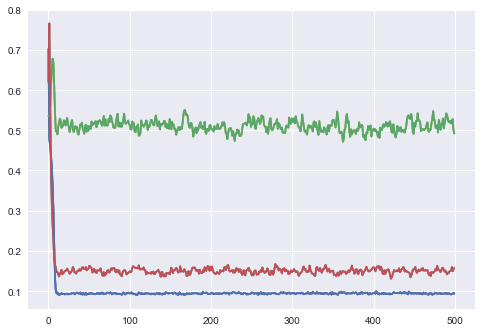

In [16]:
plt.plot(stats['sigma'])
plt.plot(stats['sigma'])
plt.plot(stats['sigma']);

In [17]:
pi_sampled = np.random.dirichlet((1,1,1))
mean_sampled = np.random.uniform(low=-1, high=1, size=3)
sigma_sampled = np.random.uniform(low=0.01, high=1, size=3)

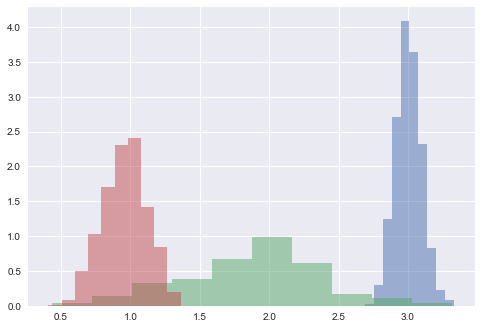

In [18]:
alpha=0.5
plt.hist(samples[np.where(stats['z'][-1]==0)], alpha=alpha, normed=True, bins=10);
plt.hist(samples[np.where(stats['z'][-1]==1)], alpha=alpha, normed=True, bins=10);
plt.hist(samples[np.where(stats['z'][-1]==2)], alpha=alpha, normed=True, bins=10);

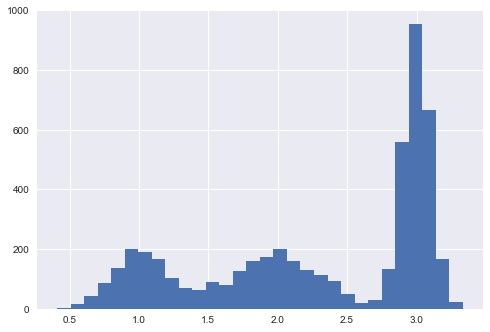

In [19]:
#seaborn.distplot(samples, kde=False, norm_hist=True)
plt.hist(samples, bins=30);